# Rainbow DQN, Deep Q Learning

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 1e-3
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

[2020-02-06 13:03:09,872] Making new env: MountainCar-v0
/Users/angga.muhammad/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(2,)
Action space Discrete(3)


## Build Noisy Network

In [9]:
class NoisyLinear(nn.Module):
    
    def __init__(self, input_features, output_features, sigma_init=0.4, train_mode=True):
        
        super(NoisyLinear, self).__init__()
        
        self.input_features = input_features
        self.output_features = output_features
        self.sigma_init = sigma_init
        self.train_mode = train_mode
        
        self.mu_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.sigma_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.register_buffer('epsilon_weight', torch.FloatTensor(output_features, input_features))
        
        self.mu_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.sigma_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.register_buffer('epsilon_bias', torch.FloatTensor(output_features))
        
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        
        mu_range = 1 / math.sqrt(self.mu_weight.size(1))
        
        self.mu_weight.data.uniform_(-mu_range, mu_range)
        self.sigma_weight.data.fill_(self.sigma_init / math.sqrt(self.sigma_weight.size(1)))
        
        self.mu_bias.data.uniform_(-mu_range, mu_range)
        self.sigma_bias.data.fill_(self.sigma_init / math.sqrt(self.sigma_bias.size(0)))
    
    def reset_noise(self):
        
        input_size = self.input_features
        epsilon_input = torch.randn(input_size)
        epsilon_input = epsilon_input.sign().mul(epsilon_input.abs().sqrt())
        
        output_size = self.output_features
        epsilon_output = torch.randn(output_size)
        epsilon_output = epsilon_output.sign().mul(epsilon_output.abs().sqrt())
        
        self.epsilon_weight.copy_(epsilon_output.ger(epsilon_input))
        self.epsilon_bias.copy_(epsilon_output)
        
    def forward(self, x):
        
        if self.train_mode:
            weight = self.mu_weight + self.sigma_weight.mul(autograd.Variable(self.epsilon_weight))
            bias = self.mu_bias + self.sigma_bias.mul(autograd.Variable(self.epsilon_bias))
        else:
            weight = self.mu_weight
            bias = self.mu_bias
            
        return F.linear(x, weight, bias)

## Build DQN Architecture

In [10]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, atom_size, v_min, v_max, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.atom_size = atom_size
        
        self.v_min = v_min
        self.v_max = v_max
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        
        # decompose state & action values
        self.noisy1_state_layer = NoisyLinear(fc2_units, fc2_units)
        self.noisy2_state_layer = NoisyLinear(fc2_units, atom_size)
        
        self.noisy1_advantage_layer = NoisyLinear(fc2_units, fc2_units)
        self.noisy2_advantage_layer = NoisyLinear(fc2_units, atom_size*action_size)
        
    def reset_noise(self):
        self.noisy1_state_layer.reset_noise(); self.noisy2_state_layer.reset_noise()
        self.noisy1_advantage_layer.reset_noise(); self.noisy2_advantage_layer.reset_noise()
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        batch_size = state.size(0)
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        
        state_value = F.relu(self.noisy1_state_layer(state))
        state_value = self.noisy2_state_layer(state_value)
        
        advantage_value = F.relu(self.noisy1_advantage_layer(state))
        advantage_value = self.noisy2_advantage_layer(advantage_value)
        
        state_value = state_value.view(batch_size, 1, self.atom_size)
        advantage_value = advantage_value.view(batch_size, self.action_size, self.atom_size)
        
        Qsa = state_value + advantage_value - advantage_value.mean(1, keepdim=True)
        Qsa = F.softmax(Qsa.view(-1, self.atom_size)).view(-1, self.action_size, self.atom_size)
        Qsa = Qsa * torch.linspace(self.v_min, self.v_max, self.atom_size)
        
        return Qsa

## Set Prioritized Replay Buffer

In [11]:
class PrioritizedReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, capacity):
        """Initialize a PrioritizedReplayMemory object."""
        pass

## Set Replay Buffer

In [12]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define Rainbow DQN Agent

In [13]:
class Rainbow_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, atom_size, v_min, v_max, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, atom_size, v_min, v_max, seed).to(device)
        self.target_net = DQN(state_size, action_size, atom_size, v_min, v_max, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = autograd.Variable(torch.from_numpy(state).float().unsqueeze(0), volatile=True).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        return action_values.sum(2).max(1)[1].numpy()[0]
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        distribution, Z_delta, supports = self.project_distribution(next_states, rewards, dones)
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1)) * supports
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        actions = actions.unsqueeze(1).expand(actions.size(0), actions.size(1), Q_target_next.size(2))
        Q_expected = self.dqn_net(states).gather(1, actions)
        Q_expected.data.clamp_(0.01, 0.99)
        
        # compute loss
        loss = - (autograd.Variable(distribution) * Q_expected.log()).sum(1)
        loss = loss.mean()
 
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # reset noise for both DQN and target networks
        self.dqn_net.reset_noise()
        self.target_net.reset_noise()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def project_distribution(self, next_states, rewards, dones):
        
        batch_size = next_states.shape[0]
        
        Z_delta = float(self.target_net.v_max - self.target_net.v_min) / (self.target_net.atom_size - 1)
        supports = torch.linspace(self.target_net.v_min, self.target_net.v_max, self.target_net.atom_size)

        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1)) * supports
        action = Q_target_next.sum(2).max(1)[1]
        action = action.unsqueeze(1).unsqueeze(1).expand(Q_target_next.size(0), 1, Q_target_next.size(2))
        Q_target_next = Q_target_next.gather(1, action).squeeze(1)
        
        rewards = rewards.expand_as(Q_target_next)
        dones = dones.expand_as(Q_target_next)
        supports = supports.expand_as(Q_target_next)
        
        Tz = rewards + (1 - dones) * 0.99 * supports
        Tz = Tz.clamp(min=self.target_net.v_min, max=self.target_net.v_max)
        b = (Tz - self.target_net.v_min) / Z_delta
        l = b.floor().long()
        u = b.ceil().long()
        
        offsets = torch.linspace(0, (batch_size - 1) * self.target_net.atom_size, batch_size).long()\
                      .unsqueeze(1).expand(batch_size, self.target_net.atom_size)
            
        distribution = torch.zeros(Q_target_next.size())
        distribution.view(-1).index_add_(0, (l + offsets).view(-1), (Q_target_next * (u.float() - b)).view(-1))
        distribution.view(-1).index_add_(0, (u + offsets).view(-1), (Q_target_next * (b - l.float())).view(-1))
        
        return distribution, Z_delta, supports
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [14]:
agent = Rainbow_DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, 
                         atom_size=51, v_min=-10, v_max=10, seed=90)

In [15]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [16]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= -200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/Rainbow_DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [17]:
scores = train_agent(num_episodes=800, max_time=1000)

Episode: 100, Average Score: -1000.00
Episode: 200, Average Score: -1000.00
Episode: 300, Average Score: -1000.00
Episode: 400, Average Score: -1000.00
Episode: 500, Average Score: -1000.00
Episode: 600, Average Score: -991.430
Episode: 700, Average Score: -940.71
Episode: 800, Average Score: -1000.00
Training completed.


## Evaluate The Agent

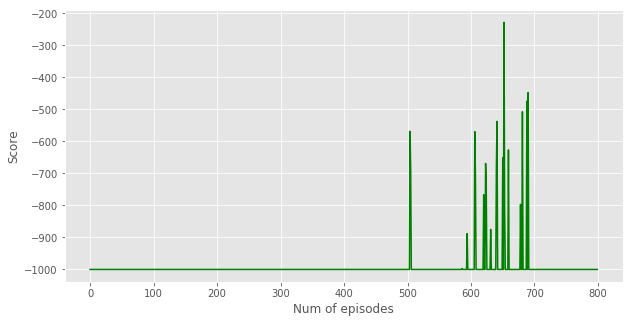

In [18]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [19]:
# load the weights of smart agent
# agent.dqn_net.load_state_dict(torch.load(f'./agents/Rainbow_DQN_{ENV_NAME}.pth'));

In [20]:
num_of_episodes = 20

for i_episode in range(1, num_of_episodes+1):
    
    state = env.reset()
    for time_step in range(200):
        
        # select an action
        action = agent.act(state)
        env.render()
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break

env.close()

---